## Import module

In [4]:
import os
import math
from collections import defaultdict
import numpy as np
import datetime
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
from matplotlib.dates import DateFormatter, WeekdayLocator, MonthLocator, DayLocator, MONDAY, YEARLY
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
# Define the work path
os.chdir('../data/')

## Plot function

In [5]:
def StandardPlot(ax, fontsize=12, grid=True, ticks=True, left=True, right=True, top=True, bottom=True):
    font_label = {'family': 'arial', 'size': fontsize}
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('arial') for label in labels]
    if grid == True:
        ax.xaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.2, zorder=0)
        ax.yaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.2, zorder=0)
    if ticks == True:
        ax.tick_params(axis='x', direction='out',
                       color='black', labelsize=fontsize, pad=3)
        ax.tick_params(axis='y', direction='in',
                       color='black', labelsize=fontsize, pad=3)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    return ax

def china_map(fig,ax,facecolor,edgecolor,linestyle,linewidth,alpha):
    for loc in [china,nine_lines]:
        ax = loc.geometry.to_crs(albers_proj).plot(  ax=ax,
                                                     facecolor=facecolor,
                                                     edgecolor=edgecolor,
                                                     linestyle=linestyle,
                                                     linewidth=linewidth,
                                                     alpha=alpha)
    ax.axis('off') # Remove the coordinate axes
    ax.set_xlim(bound.geometry[0].x, bound.geometry[1].x)
    ax.set_ylim(bound.geometry[0].y, bound.geometry[1].y)
    ax_child = nine_dot(fig,china,facecolor,edgecolor,linestyle,linewidth,alpha)
    return china,ax_child

def nine_dot(fig,china,facecolor,edgecolor,linestyle,linewidth,alpha):
    ax_child = fig.add_axes([0.75, 0.15, 0.2, 0.2])
    for loc in [china,nine_lines]:
        ax_child = loc.geometry.to_crs(albers_proj).plot(  ax=ax_child,
                                                             facecolor=facecolor,
                                                             edgecolor=facecolor,
                                                             linestyle=linestyle,
                                                             linewidth=linewidth,
                                                             alpha=alpha)
    ax_child.set_xlim(bound.geometry[2].x, bound.geometry[3].x)
    ax_child.set_ylim(bound.geometry[2].y, bound.geometry[3].y)
    ax_child.set_xticks([])
    ax_child.set_yticks([])
    return ax_child


## Temporal distribution of SARS-CoV-2 sequences data globally

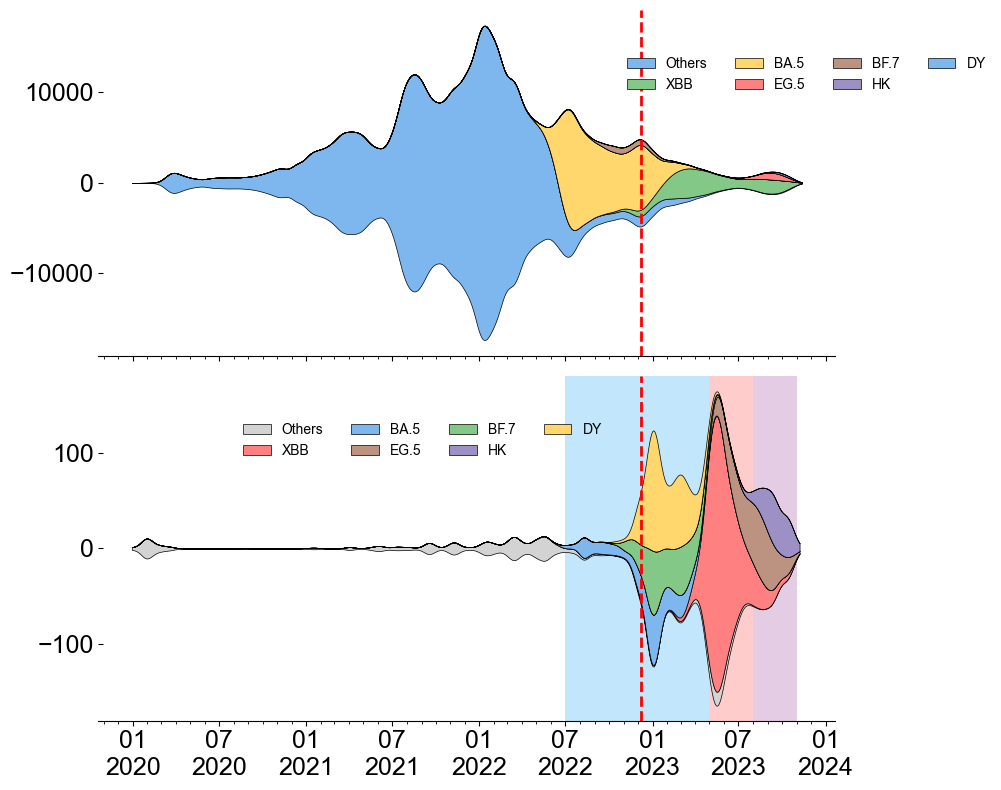

In [6]:
def temp_dist_global(ax):
    def gaussian_smooth(x, y, grid, sd):
        weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
        weights = weights / weights.sum(0)
        return (weights * y).sum(1)
    df = pd.read_csv('Overseas_total.csv')
    df['Omicron sublineages'] = ['Others' if i not in dominant_Omicron_sublineages else i for i in df['Omicron sublineages']]
    lineage_lst =  df['Omicron sublineages'].unique().tolist()
    lineage_lst_sorted = ['Others','XBB','BA.5','EG.5','BF.7','HK','DY']
    t_lst = df['Collection date'].unique().tolist()
    t_lst = [str(i.date()) for i in pd.date_range(start=t_lst[0], end=t_lst[-1], freq='D')]
    lineage_t_dct = {i:{j:0 for j in t_lst} for i in lineage_lst}
    for x,y in df['Accession ID'].groupby([df['Omicron sublineages'],df['Collection date']]):
        lineage_t_dct[x[0]][x[1]] = len(y)
    lineage_dct = defaultdict(list)
    for lineage in lineage_lst:
        for t in t_lst:
            lineage_dct[lineage].append(lineage_t_dct[lineage][t])
    color_dct =  {'Others': 'lightgrey','BA.5':'#7EB6EE','BF.7':'#84C887','DY':'#FFD76D','XBB':'#FF8080',
                'EG.5':'#BC9281','HK':'#9D90C5'}
    lineage_dct = dict(sorted(lineage_dct.items(),key = lambda x:lineage_lst_sorted.index(x[0])))
    color_lst =[color_dct[i] for i in dominant_Omicron_sublineages]
    colors = [color_dct[i] for i in lineage_dct.keys()]
    Y = np.array(list(lineage_dct.values()))
    X = []
    for n,t in enumerate(t_lst):
        X.append(n+1)
    grid = np.linspace(X[0],X[-1] , num=len(X))
    x_ticks = [datetime.datetime.fromordinal(int(datetime.datetime(2019,12,30).toordinal()+ (i-1))) for i in grid]
    y_smoothed = [gaussian_smooth(X, y_, grid, 10) for y_ in Y]
    ax.stackplot(x_ticks, y_smoothed, 
                 alpha = 1,linewidth = 0.5,edgecolor = 'k', colors = color_lst,
                 baseline="sym",
                 labels=lineage_lst_sorted
                )
    ax = StandardPlot(ax,fontsize=fontsize,left=False,right= False,top = False,grid = False,ticks = True)
    ax.legend(
              lineage_lst_sorted,
              ncols = 4,
              bbox_to_anchor = (0.7,0.9),
              # loc = 'upper left',
              prop={'family': 'arial', 'size': 10},frameon=False)
    monthdays = MonthLocator()
    ax.xaxis.set_minor_locator(monthdays)
    ax.xaxis.set_major_formatter(DateFormatter('%m\n%Y')) 
    ax.set(xlabel=None)
    t_lift = datetime.datetime.strptime('2022-12-07', '%Y-%m-%d')
    ax.axvline(x=t_lift,linewidth = 2,color = 'red',linestyle='--',alpha = 1)
    return ax

def temp_dist_CN(ax): 
    def gaussian_smooth(x, y, grid, sd):
        weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
        weights = weights / weights.sum(0)
        return (weights * y).sum(1)

    df = pd.read_csv('cn_meta_unredund.csv')
    prov_lst = ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou',
                'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu',
                'Jiangxi', 'Jilin', 'Liaoning', 'Neimenggu', 'Ningxia', 'Qinghai',
                'Shaanxi', 'Shandong', 'Shanghai2', 'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang', 'Xizang', 'Yunnan', 'Zhejiang']
    df['Omicron sublineages'] = ['Others' if i not in dominant_Omicron_sublineages else i for i in df['Omicron sublineages']]
    lineage_lst =  df['Omicron sublineages'].unique().tolist()
    lineage_lst_sorted = ['Others','XBB','BA.5','EG.5','BF.7','HK','DY']
    t_lst = df['Collection date'].unique().tolist()
    t_lst = [str(i.date()) for i in pd.date_range(start=t_lst[0], end=t_lst[-1], freq='D')]
    lineage_t_dct = {i:{j:0 for j in t_lst} for i in lineage_lst}
    for x,y in df['Accession ID'].groupby([df['Omicron sublineages'],df['Collection date']]):
        lineage_t_dct[x[0]][x[1]] = len(y)
    lineage_dct = defaultdict(list)
    for lineage in lineage_lst:
        for t in t_lst:
            lineage_dct[lineage].append(lineage_t_dct[lineage][t])
    color_dct =  {'Others': 'lightgrey','BA.5':'#7EB6EE','BF.7':'#84C887','DY':'#FFD76D','XBB':'#FF8080',
                  'EG.5':'#BC9281','HK':'#9D90C5'}
    lineage_lst_sorted = ['Others','XBB','BA.5','EG.5','BF.7','HK','DY']
    lineage_dct = dict(sorted(lineage_dct.items(),key = lambda x:lineage_lst_sorted.index(x[0])))
    color_lst =[color_dct[i] for i in lineage_lst_sorted]

    colors = [color_dct[i] for i in lineage_dct.keys()]
    Y = np.array(list(lineage_dct.values()))
    X = []
    for n,t in enumerate(t_lst):
        X.append(n+1)
    grid = np.linspace(X[0],X[-1] , num=len(X))
    x_ticks = [datetime.datetime.fromordinal(int(datetime.datetime(2019,12,30).toordinal()+ (i-1))) for i in grid]
    y_smoothed = [gaussian_smooth(X, y_, grid, 10) for y_ in Y]
    ax.stackplot(x_ticks, y_smoothed, 
                 linewidth = 0.5,edgecolor = 'k', colors = color_lst,
                 baseline="sym",
                 labels=lineage_lst_sorted
                )
    ax = StandardPlot(ax,fontsize=fontsize,left=False,right= False,top = False,grid = False,ticks = True)
    ax.legend(
              lineage_lst_sorted,
              ncols = 4,
              bbox_to_anchor = (0.7,0.9),
              # loc = 'upper left',
              prop={'family': 'arial', 'size': 10},frameon=False)
    monthdays = MonthLocator()
    ax.xaxis.set_minor_locator(monthdays)
    ax.xaxis.set_major_formatter(DateFormatter('%m\n%Y')) 
    ax.set(xlabel=None)
    t1 = datetime.datetime.strptime('2022-07-01', '%Y-%m-%d')
    t2 = datetime.datetime.strptime('2023-05-01', '%Y-%m-%d')
    t3 = datetime.datetime.strptime('2023-08-01', '%Y-%m-%d')
    t4 = datetime.datetime.strptime('2023-11-01', '%Y-%m-%d')
    t_lift = datetime.datetime.strptime('2022-12-07', '%Y-%m-%d')
    ax.axvspan(t1, t2, facecolor='#87CEFA',alpha = 0.5,zorder = 0)
    ax.axvspan(t2, t3, facecolor='red',alpha = 0.2,zorder =0)
    ax.axvspan(t3, t4, facecolor='purple',alpha = 0.2,zorder = 0)
    ax.axvline(x=t_lift,linewidth = 2,color = 'red',linestyle='--',alpha = 1)
    return ax
dominant_Omicron_sublineages = ['BA.5','BF.7','DY','XBB','EG.5', 'HK']
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(2,1,figsize=(10, 8),sharex='all')
fontsize = 18
ax_array = ax.flatten()
ax1,ax2 = ax_array[0],ax_array[1]
ax1 = temp_dist_global(ax1)
ax2 = temp_dist_CN(ax2)
plt.tight_layout()
plt.show()


## Map showing the sequences geographic distribution in the Chinese mainland

/home/yanxu/miniconda3/envs/zc/lib/python3.9/site-packages/geopandas/geodataframe.py:221: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  object.__setattr__(self, attr, val)
/tmp/ipykernel_2342170/3205858231.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


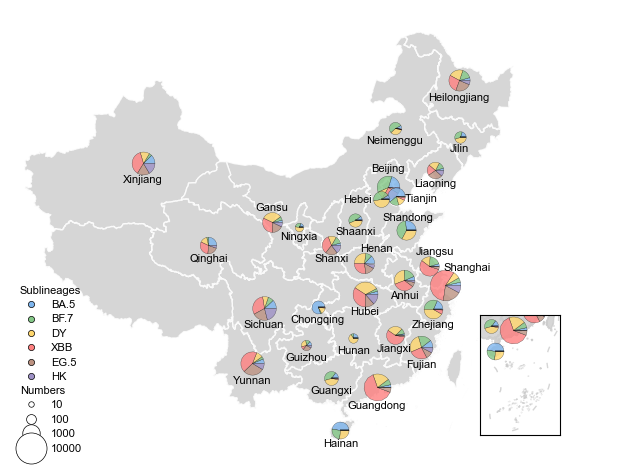

In [8]:
def drawPieMarker(ax,xs, ys, ratios, sizes, colors):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})
    # scatter each of the pie pieces to create pies
    for marker in markers:
        p = ax.scatter(xs, ys, **marker,edgecolor = 'k',linewidth = 0.2,alpha = 0.8)
    return ax

china = gpd.read_file('shpfile/china.shp',encoding='utf-8')
china = china.dissolve(by='OWNER').reset_index(drop=False)
nine_lines = gpd.read_file('shpfile/china_nine_dotted_line.shp',encoding='utf-8')
albers_proj = '+proj=aea +lat_1=25 +lat_2=47 +lon_0=105'
bound = gpd.GeoDataFrame({
    'x': [80, 150, 106.5, 123],
    'y': [15, 50, 2.8, 24.5]
})
bound.geometry = bound.apply(lambda row: Point([row['x'], row['y']]), axis=1)
bound.crs = 'EPSG:4326'
bound.to_crs(albers_proj, inplace=True)
color_dct =  {'Others': 'lightgrey','BA.5':'#7EB6EE','BF.7':'#84C887','DY':'#FFD76D','XBB':'#FF8080',
            'EG.5':'#BC9281','HK':'#9D90C5'}
dominant_Omicron_sublineages = ['BA.5','BF.7','DY','XBB','EG.5', 'HK']
df = pd.read_csv('cn_meta_unredund.csv')
prov_lineage_seq_dct = defaultdict(dict)
for x,y in df['Accession ID'].groupby([df['Province'],df['Omicron sublineages']]):
    prov_lineage_seq_dct[x[0]].update({x[1]:len(y)})
df_seqnum = pd.DataFrame(prov_lineage_seq_dct).T
df_seqnum = df_seqnum[dominant_Omicron_sublineages].fillna(0)
prov_seq_dct = {}
for i in df_seqnum.index:
    prov_seq_dct[i] = list(df_seqnum.loc[i])
plt.rcParams['pdf.fonttype'] = 42
fontsize = 12
font_label = {'family': 'Arial', 'size': fontsize}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 1, 1))
facecolor = '#CCCCCC'
edgecolor = 'white'
linestyle = '-'
linewidth = 1
alpha = 0.8
china,ax_child = china_map(fig,ax,facecolor,edgecolor,linestyle,linewidth,alpha)
exclude_loc = ['Huangwei','Aomen','Hongkong']
prov_shft = {'Ningxiahuizu':'Ningxia','Neimongol':'Neimenggu','SHanxi':'Shaanxi','Guangxizhuangzu':'Guangxi','Xinjianguygur':'Xinjiang'}
pos_dct = {}
for idx, _ in enumerate(china.geometry.representative_point().to_crs(albers_proj)):
    region = china.loc[idx, 'FENAME'].split()[0]
    if region in prov_shft:
        region = prov_shft[region]
    if region not in exclude_loc:
        pos_dct[region] = (_.x,_.y)
labelsize = 8
s_alpha = 1
s_width = 0.5
rat = 0.2
font_pos_dct = {'Anhui':[0,-150000], 'Beijing':[0,185000], 'Chongqing':[0,-110000], 'Fujian':[0,-170000], 'Gansu':[0,150000], 'Guangdong':[0,-180000], 
'Guangxi':[0,-120000], 'Guizhou':[0,-120000],'Hainan':[0,-130000], 'Hebei':[-240000,0], 'Heilongjiang':[0,-160000], 
'Henan':[120000,150000], 'Hubei':[0,-170000], 'Hunan':[0,-120000], 'Jiangsu':[60000,150000],'Jiangxi':[0,-130000], 
'Jilin':[0,-110000], 'Liaoning':[0,-125000], 'Neimenggu':[0,-120000], 'Ningxia':[0,-90000], 'Qinghai':[0,-130000],
'Shaanxi':[0,-110000], 'Shandong':[20000,130000], 'Shanghai':[220000,170000], 'Shanxi':[0,-130000], 'Sichuan':[0,-160000], 
'Tianjin':[250000,-20000], 'Xinjiang':[0,-160000], 'Yunnan':[0,-160000], 'Zhejiang':[0,-150000]
}
for name,(x_,y_) in pos_dct.items():
    if name in prov_seq_dct:
        ax.text(x_+font_pos_dct[name][0],y_+font_pos_dct[name][1],name,fontsize = 8,horizontalalignment='center',verticalalignment = 'center')
        num_lst = prov_seq_dct[name]
        ratio_lst = [i/sum(num_lst) for i in num_lst]
        if sum(ratio_lst)>1:
            ratio_lst = [int(i/sum(num_lst)*100)/100 for i in num_lst]    
        drawPieMarker(ax,
              xs=x_,
              ys=y_,
              ratios=ratio_lst,
              sizes= [math.sqrt(sum(num_lst))/rat],
              colors=[color_dct[i] for i in dominant_Omicron_sublineages])    
        drawPieMarker(ax_child,
              xs=x_,
              ys=y_,
              ratios=ratio_lst,
              sizes= [math.sqrt(sum(num_lst))/rat],
              colors=[color_dct[i] for i in dominant_Omicron_sublineages])     
label1 = ['10','100','1000','10000']
p_lineage_lst = []
for lineage in dominant_Omicron_sublineages:
    pi = ax.scatter([], [], c=color_dct[lineage],s=20,edgecolor='k', linewidth = s_width,alpha=s_alpha, zorder = -1,label =lineage)
    p_lineage_lst.append(pi)
legend_ax2 = ax.legend(p_lineage_lst,dominant_Omicron_sublineages,frameon=False,title = 'Sublineages',title_fontsize=labelsize,alignment = 'left',
        labelspacing=0.4, loc='lower left', fontsize=labelsize,columnspacing=0,
        bbox_to_anchor=(0.0,0.115),)
legend_labels2 =legend_ax2.get_texts()
[label.set_fontname('arial') for label in legend_labels2] 
legend_ax2.get_title().set_fontname('arial')    
p1 = ax.scatter([], [], c='white',s=math.sqrt(10)/rat,edgecolor='k', linewidth = s_width,alpha=s_alpha, zorder = -1)
p2 = ax.scatter([], [], c='white', s=math.sqrt(100)/rat,edgecolor='k', linewidth = s_width,alpha=s_alpha,zorder = -1)
p3 = ax.scatter([], [], c='white', s=math.sqrt(1000)/rat,edgecolor='k', linewidth = s_width,alpha=s_alpha, zorder = -1)
p4 = ax.scatter([], [], c='white', s=math.sqrt(10000)/rat,edgecolor='k', linewidth =s_width,alpha=s_alpha, zorder = -1)
legend_ax1 = ax.legend([p1,p2,p3,p4],label1, frameon=False,title = 'Numbers',title_fontsize=labelsize,alignment = 'left',
        labelspacing=0.4, loc='lower left', fontsize=labelsize,
        bbox_to_anchor=(0.0,-0.05))
legend_abelss =legend_ax1.get_texts()
[label.set_fontname('arial') for label in legend_abelss]    
legend_ax1.get_title().set_fontname('arial')    
ax.add_artist(legend_ax2)    
plt.tight_layout()
plt.show()
